In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

# Feature Engineering with Linear Regression

## Our Data

The Ames Housing Data Set:<br>
Dean De Cock<br>
Truman State University<br>
Journal of Statistics Education Volume 19, Number 3(2011)<br>
www.amstat.org/publications/jse/v19n3/decock.pdf

## Our Process

In this notebook, we will build some linear regression models to predict housing prices from this data. We will set out to *improve on a baseline* set of features via **feature engineering**: deriving new features from our existing data. 

Feature engineering often makes the difference between a weak or decent model and a strong one. Sometimes feature engineering can be more effective than model selection and hyperparameter tuning when it comes to improving prediction accuracy!

For the sake of simplicity, we will split our data into training and validation sets, build models on various feature sets and compare their results on the validation set. We will use visual exploration, domain understanding, and intuition to construct new features that add significant predictive signal, which will be apparent in validation *r-squared* scores.

## 1. EDA

### Load the Data

In [43]:
# Load in the Ames Housing Data
datafile = "/Users/gavin/Documents/Metis/Coursework/Project_2/df_all_stat.csv"

def get_ames(datafile):
    df = pd.read_csv(datafile)
    return df

In [44]:
df_ames = get_ames(datafile)

In [45]:
# There are a lot of columns, so we'll only pick a select few
keep = ['Price', 'Year_Built', 'Interior_Sq_Ft', 'beds','Price', 'Baths', 'Half_Bath_(F)', 'zipcode_median', 'Neighborhood_median', 'Miles to Penn Station']

# We make a copy because we'll be doing some transformations later
df_ames_ = df_ames[keep].copy()

In [46]:
df_ames_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1283 non-null   float64
 1   Year_Built             1283 non-null   float64
 2   Interior_Sq_Ft         1283 non-null   float64
 3   beds                   1283 non-null   float64
 4   Price                  1283 non-null   float64
 5   Baths                  1283 non-null   float64
 6   Half_Bath_(F)          1283 non-null   float64
 7   zipcode_median         1283 non-null   float64
 8   Neighborhood_median    1283 non-null   float64
 9   Miles to Penn Station  1283 non-null   float64
dtypes: float64(10)
memory usage: 100.4 KB


In [47]:
df_ames_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1283 non-null   float64
 1   Year_Built             1283 non-null   float64
 2   Interior_Sq_Ft         1283 non-null   float64
 3   beds                   1283 non-null   float64
 4   Price                  1283 non-null   float64
 5   Baths                  1283 non-null   float64
 6   Half_Bath_(F)          1283 non-null   float64
 7   zipcode_median         1283 non-null   float64
 8   Neighborhood_median    1283 non-null   float64
 9   Miles to Penn Station  1283 non-null   float64
dtypes: float64(10)
memory usage: 100.4 KB


Now that we have a nice, filtered dataset, let's generate visuals to better understand the target and feature-target relationships: PairGrid is great for this!

**Note: Normally, here we'd separate a "holdout" set of data (one that we don't know anything about until the very end). But, there's not a lot of data to work with here, so we'll consiously neglect that for now.**

### Explore Data

In [55]:
# Sometimtes plotting PairGrid takes a while, and we don't need to see *all* the data, so a sample will do
%config InlineBackend.figure_formats = ['png']

g = sns.pairplot(df_ames_.sample(frac=0.6), diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot, kde=False)

TypeError: pairplot() got an unexpected keyword argument 'diag_sharey'

In [10]:
%config InlineBackend.figure_formats = ['svg']

---

**Data Exploration Exercises**: 

1. Is there anything that looks *weird* (really, *anything* that catches your eye!)?
2. Look at feature-feature and feature-target relationships. Is there anything worrying?
3. Investigate, and interpret what you see!

---

## 2. Model Setup

In [11]:
# Separate our features from our target
features = [c for c in df_ames_ if c != 'SalePrice']

X = df_ames_[features]
y = df_ames_['SalePrice']

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Bedroom AbvGr   2925 non-null   int64  
 8   Fireplaces      2925 non-null   int64  
 9   Garage Cars     2925 non-null   float64
dtypes: float64(1), int64(9)
memory usage: 251.4 KB


### Baseline Model

Now that we have feature/target data X, y ready to go, we're ready to fit and evaluate a baseline model using our current feature set. We will use cross validation to score the model. 

Since we'll be reusing the same cross validation scoring scheme for each feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [13]:
from sklearn.model_selection import cross_validate

def cv_results(X, y, model=LinearRegression(normalize=True), scoring='r2', rounding=4, cv=5, minimize_score=False):
    '''
    For a set of features and target X, y, perform a 5 fold cross validation.
    Fit and validate a model, and report results
    Note: `sklearn.model_selection.cross_validate` defaults to 5 fold, 80/20 validation splits.
    '''
    
    model_cv = cross_validate(model, X, y, cv=cv, return_train_score=True, 
                              scoring=scoring, return_estimator=True)

    if minimize_score:
        select = model_cv['test_score'].argmin()
    else:
        select = model_cv['test_score'].argmax()

    final_model = model_cv['estimator'][select]
    
    # Capture the ratio between the train and test scores to understand possible under/over fitting
    model_cv['train_test_score_ratio'] = model_cv['train_score'] / model_cv['test_score']
    
    mean_score = round(model_cv['test_score'].mean(), rounding)
    min_score = round(model_cv['test_score'].min(), rounding)
    max_score = round(model_cv['test_score'].max(), rounding)
    
    mean_ratio = round(model_cv['train_test_score_ratio'].mean(), rounding)
    min_ratio = round(model_cv['train_test_score_ratio'].min(), rounding)
    max_ratio = round(model_cv['train_test_score_ratio'].max(), rounding)
    
    # report results
    print(f'Test {scoring} {":":<15} Mean = {mean_score}\tRange = ({min_score}, {max_score})')
    print(f'Train/Test {scoring} Ratio {":":<3} Mean = {mean_ratio}\tRange = ({min_ratio}, {max_ratio})')
    
    print('\nBest Model Feature coefficient results:')
    for feature, coef in zip(X.columns, final_model.coef_):
        print(f'{feature + ":":<16} {coef:.2f}')

In [14]:
cv_results(X, y)

Test r2 :               Mean = 0.8156	Range = (0.7999, 0.8313)
Train/Test r2 Ratio :   Mean = 1.0074	Range = (0.9838, 1.0322)

Best Model Feature coefficient results:
Lot Area:        0.99
Overall Qual:    20244.66
Overall Cond:    4169.64
Year Built:      521.78
Year Remod/Add:  197.79
Gr Liv Area:     75.34
Full Bath:       -10259.95
Bedroom AbvGr:   -11695.17
Fireplaces:      6913.64
Garage Cars:     10678.38


-----

**Review Exercise**: How is the $R^2$ score defined? What does this score mean intuitively? What are possible drawbacks of using the $R^2$ score for evaluation? 

-----

## 2. Polynomial Terms

When looking at the pair plot above, certain features like _'Overall Qual'_ and _'Gr Liv Qual'_ seem to have an upward-curved relationship with the target, rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Suppose y = x^2  <- x^2 is our feature

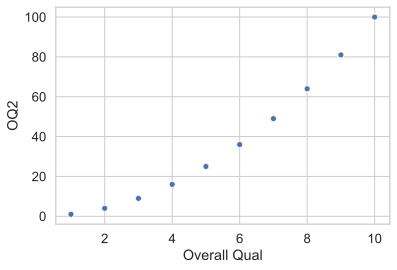

In [18]:
sns.scatterplot(y=X2['OQ2'], x=X2['Overall Qual'])

In [19]:
Then \sqrt(y) = x

SyntaxError: unexpected character after line continuation character (<ipython-input-19-250669e492e6>, line 1)

In [17]:
X2 = X.copy()

X2['OQ2'] = X2['Overall Qual'] ** 2
X2['GLA2'] = X2['Gr Liv Area'] ** 2

cv_results(X2, y)

Test r2 :               Mean = 0.861	Range = (0.8275, 0.8807)
Train/Test r2 Ratio :   Mean = 1.0065	Range = (0.9788, 1.056)

Best Model Feature coefficient results:
Lot Area:        1.14
Overall Qual:    -51010.16
Overall Cond:    8138.13
Year Built:      609.26
Year Remod/Add:  106.22
Gr Liv Area:     21.80
Full Bath:       -7067.76
Bedroom AbvGr:   -5200.57
Fireplaces:      9130.99
Garage Cars:     8910.98
OQ2:             5843.94
GLA2:            0.01


As we might expect, adding appropriate square terms allows our model to do a significantly better job (+.05 R^2) capturing certain feature-target relationships that are closer to quadratic than linear. If we saw higher-order curve relationships, we could try adding higher degree polynomial terms as well.

**Note**: Feature transformations are not limited to polynomial terms and can also include log and square root transforms among others. Balance your intuition and experience with what you see in feature-target plots, and validate!

-----
**Polynomial Feature Exercise**: Based on inspecting the pairplot, what other features do you think polynomial terms may be helpful for? Try adding them to X2 and rerunning `cv_results`. Is the improvement less than you expected? What do you think happened?  

-----

## 3. Interaction Terms

With our current feature set, no feature value has influence over how the model views other features' values. Each feature is treated as a completely independent quantity. However, there may easily be **interaction effects** present, in which the impact of one feature may be dependent on the current value of a different feature.

### Multiplicative

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

See below, where the upper portion of the plot represents more recent houses, and the lower represents older houses. Notice how the increase in `Overall Qual` (from left to right) yields a higher increase in `SalesPrice` for more recent houses than older houses?

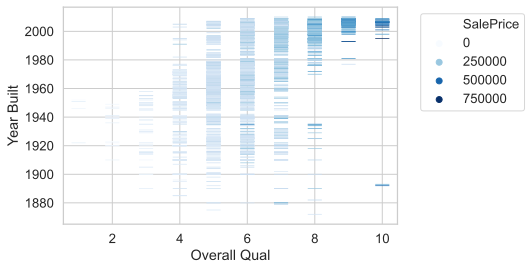

In [16]:
sns.scatterplot(data=pd.concat((X2, y), axis=1), 
                x='Overall Qual', 
                y='Year Built',
                hue='SalePrice',
                palette='Blues',
                s=200,
                marker='_')

plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right');

### Ratio

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

In [17]:
X3 = X2.copy()

# multiplicative interaction
X3['OQ_x_YB'] = X3['Overall Qual'] * X3['Year Built']

# division interaction
X3['OQ_/_LA'] = X3['Overall Qual'] / X3['Lot Area']

cv_results(X3, y)

Test r2 :               Mean = 0.8722	Range = (0.8421, 0.8927)
Train/Test r2 Ratio :   Mean = 1.0054	Range = (0.9767, 1.0487)

Best Model Feature coefficient results:
Lot Area:        0.66
Overall Qual:    -305048.22
Overall Cond:    8555.40
Year Built:      -165.81
Year Remod/Add:  105.10
Gr Liv Area:     15.98
Full Bath:       -6868.94
Bedroom AbvGr:   -6562.04
Fireplaces:      9574.34
Garage Cars:     7359.60
OQ2:             4326.64
GLA2:            0.01
OQ_x_YB:         138.98
OQ_/_LA:         -14280550.94


Great, they gave us a slight additional boost of .01 R^2.

-----
**Interaction Feature Exercise**: What other interactions do you think might be helpful? Try adding them to X3 and measuring your results!  

-----

## 4. Categorical Encoding

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

In [18]:
df_ames['House Style'].value_counts()

1Story    1480
2Story     869
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: House Style, dtype: int64

There are not a lot of houses in the last three styles, so lets only concern ourselves with the styles that take up, say 96% of the data (see below).

In [19]:
styles = df_ames['House Style'].value_counts(normalize=True).cumsum()
styles

1Story    0.505983
2Story    0.803077
1.5Fin    0.910427
SLvl      0.954188
SFoyer    0.982564
2.5Unf    0.990769
1.5Unf    0.997265
2.5Fin    1.000000
Name: House Style, dtype: float64

In [20]:
# Call it "other" if it isn't captured in the first 96% of the data
other_styles = list(styles[styles > 0.96].index)
other_styles

['SFoyer', '2.5Unf', '1.5Unf', '2.5Fin']

In [21]:
X4 = X3.copy()
X4['House Style'] = df_ames['House Style'].replace(other_styles, 'Other')

This looks ok, and here's a quick look at how dummy features actually appear:

In [22]:
pd.get_dummies(X4['House Style']).sample(5)

,1.5Fin,1Story,2Story,Other,SLvl
1975,1,0,0,0,0
1627,0,0,0,0,1
107,0,1,0,0,0
2343,1,0,0,0,0
340,0,0,1,0,0


We can call `pd.get_dummies()` on our entire dataset to quickly get data with all the original features and dummy variable representation of any categorical features. Let's do that below and run a new benchmark!

In [23]:
cv_results(pd.get_dummies(X4, columns=['House Style']), y)

Test r2 :               Mean = 0.8761	Range = (0.8516, 0.8965)
Train/Test r2 Ratio :   Mean = 1.0067	Range = (0.9783, 1.0413)

Best Model Feature coefficient results:
Lot Area:        0.62
Overall Qual:    -311888.06
Overall Cond:    8841.76
Year Built:      -194.06
Year Remod/Add:  122.84
Gr Liv Area:     32.04
Full Bath:       -7490.31
Bedroom AbvGr:   -5304.98
Fireplaces:      8782.31
Garage Cars:     7219.88
OQ2:             4051.76
GLA2:            0.01
OQ_x_YB:         143.59
OQ_/_LA:         -10658401.72
House Style_1.5Fin: 156.46
House Style_1Story: 7458.21
House Style_2Story: -8276.78
House Style_Other: 2186.01
House Style_SLvl: -6032.36


So, that didn't really change much. But, if we're using our model solely for prediction, we may be okay leaving the features in. Notice that the difference between our train/test $R^2$ isn't too egregious.

---

**Exercise: What if our categories were something like `House_Size: {"Small", "Medium", "Large"}`? How should we interpret these as a new numerical feature?** *Hint: Consider the Pandas Category object.*

---

### Categorical Interactions

We may also find that the relationship between a continuous variable (say, Garage Car count, roughly) and our target is dependent on a categorical feature (say, House Style). In this case, we would need to consider interaction terms between the dummy variables we created, and the continuous variables.

*It's rough, but notice how there are different trend lines for different `House Style`s?*

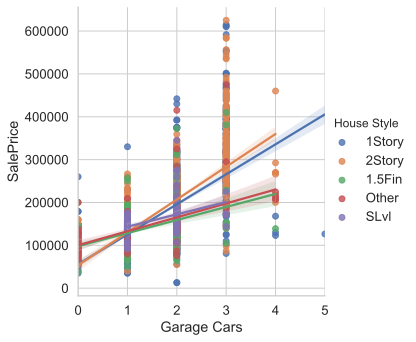

In [24]:
sns.lmplot(data=pd.concat((X4, y), axis=1), x='Garage Cars', y='SalePrice', hue='House Style')

--- 

**Exercise: How can we incorporate this into the model?**

---

### Deviation Feature

We'll create features that capture where a feature value lies relative to the members of a category it belongs to. In particular, we'll calculate the normalized deviance of a row's feature value from the mean value of the category that row belongs to. This helps to capture information about a feature relative to the category's distribution, e.g. how nice a house is relative to other houses in its neighborhood or of its style.

In [25]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature

**Refer to the documenation on [`.transform`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.SeriesGroupBy.transform.html).** There is a nice difference between this and the typical `df.groupby(col)[var].mean()` type syntax.

In [26]:
X5 = X4.copy()

add_deviation_feature(X5, 'Year Built', 'House Style')

cv_results(pd.get_dummies(X5), y)

Test r2 :               Mean = 0.876	Range = (0.8515, 0.8958)
Train/Test r2 Ratio :   Mean = 1.0069	Range = (0.9793, 1.0415)

Best Model Feature coefficient results:
Lot Area:        0.62
Overall Qual:    -298872.48
Overall Cond:    8785.32
Year Built:      106.36
Year Remod/Add:  129.36
Gr Liv Area:     33.82
Full Bath:       -7421.25
Bedroom AbvGr:   -5266.55
Fireplaces:      8580.75
Garage Cars:     7182.18
OQ2:             4116.56
GLA2:            0.01
OQ_x_YB:         136.66
OQ_/_LA:         -10513631.79
Year Built_Dev_House Style: -7365.06
House Style_1.5Fin: 9207.97
House Style_1Story: 6047.57
House Style_2Story: -11118.34
House Style_Other: 5628.99
House Style_SLvl: -7391.15


Well it didn't help much, but it did help a bit!

# Measurement (or "Transformation") Bias

A strange thing happens when we perform feature engineering: We can increase the performance of our model on test data (after having it trained on another training set), but we are inherently *creating* (or measuring) attributes of observations (or entities) in an attempt to define them. It may be that our measurements are well suited for our training/test set, but it's also possible that the same measurements (or in some cases, proxies) only benefit the model because those things we measure are consequences of some actor outside our system.

For example, suppose we capture the time difference between the year built and year remodeled. What are we showing? What if our data is mostly houses that have been remodeled, but we end up using this model on many houses that have not yet been remodeled? Is that relationship being missed?

These are just some topics to think about when we feature engineer. Consider deviance factors, ensembled models, or simple excluding some features.

## Workflow Recap

**$R^2$ Benchmarks**:

1. Baseline feature set: ~0.82
2. Polynomial transforms: ~.86
3. Interaction terms: ~.87
4. Category features (house style): ~.88
5. Deviation features: ~.88

As you can see, feature engineering often follows a sort of [_Pareto principle_](https://en.wikipedia.org/wiki/Pareto_principle), where a large bulk of the predictive gains can be reached through adding a set of intuitive, strong features like polynomial transforms and interactions. Directly incorporating additional information like categorical variables and deviation can also be very helpful. 

Beyond this point, additional feature engineering can provide significant, but potentially diminishing returns. Whether it's worth making the extra effort is very dependent on the use case for the model!

### What are some other features we could engineer?

- Cumulative Sums
- Moving Windows
- Minimums/Maximums/Means within groups
- Ratios
- Differences
- Shifts (e.g., Time Series)
- Etc.

-----
**Further Practice Exercise**: Gamify this to practice your feature engineering skills! How far can you push the validation R^2 score with
the features we've used so far? Can you bring in new features from the original dataframe to boost the score even more? 

-----

-----
**Reflection Question**: What problems do you foresee with highly extensive feature engineering? Is the model still easy to interpret and explain? What issues might arise if we were working with a massive dataset (say 100 million+ records) instead of only a few thousand?   

-----